# Two qubit operations

In [1]:
from qiskit import (QuantumCircuit,
                        QuantumRegister,
                        ClassicalRegister,
                        execute,
                        Aer)
import numpy as np
from qiskit.visualization import plot_histogram

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [2]:
from qiskit import transpile
qc = QuantumCircuit(1)
qc.initialize([1/np.sqrt(2), 1/np.sqrt(2)], 0)
print(qc)
new_qc = transpile(qc, basis_gates=["cx", "u3"])
print(new_qc)

        ┌─────────────────────────────┐
q_0: |0>┤ Initialize(0.70711,0.70711) ├
        └─────────────────────────────┘
        ┌──────────────┐
q_0: |0>┤ U3(pi/2,0,0) ├
        └──────────────┘


In [3]:
def show_result(qc, histogram = False):
    job = execute(qc, backend = Aer.get_backend("statevector_simulator"))
    vec = job.result().get_statevector(qc)
    
    bins = [format(i, '0%db'%np.ceil(np.log2(len(vec)))) for i, _ in enumerate(vec)]
    for i, j in zip(vec, bins):
        print(i, ": |%s>"%str(j))
    if histogram:
        display(plot_histogram(job.result().get_counts()))
        display(qc.draw(output = 'mpl'))

### Q1. Create state 
$$|\psi_0\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$$

In [4]:
qc = QuantumCircuit(2, 2)

qc.h(0)
qc.cx(0, 1)

show_result(qc)

(0.7071067811865476+0j) : |00>
0j : |01>
0j : |10>
(0.7071067811865475+0j) : |11>


### Q2. Create state 
$$|\psi_0\rangle = \frac{|01\rangle + |10\rangle}{\sqrt{2}}$$

In [5]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q, c)

qc.h(0)
qc.cx(0, 1)
qc.x(0)

show_result(qc)

0j : |00>
(0.7071067811865476+0j) : |01>
(0.7071067811865475+0j) : |10>
0j : |11>


### Q3. Validate CHSH inequality (A little bit advanced)
What is CHSH inequality? https://en.wikipedia.org/wiki/CHSH_inequality  
Briefly, CHSH inequality is a proof of bell's theorem.   
Usually, CHSH inequality satisfies
$$|\langle{A, B}\rangle-\langle{a, B}\rangle+\langle{A, b}\rangle + \langle{a, b}\rangle| \leq 2$$  
in a classical system. However, in a quantum system, this inequality satisfies
$$2 < |\langle{A, B}\rangle-\langle{a, B}\rangle+\langle{A, b}\rangle + \langle{a, b}\rangle|\leq2\sqrt{2}$$  
A, B, a, b represent the basis of measurement.

#### First step (prepare quantum circuit)
We need two qubits to simulate CHSH inequality.

In [6]:
def create_qc():
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    ## you cannot measure here because if you measure here, you cannot change the measurement basis  
#     qc.measure(0, 0)
    return qc

#### Second step (prepare bell state)
Bell state is one of the most important quantum states. There are four types of bell states.
$$|\Phi^{+}\rangle = \frac{|00\rangle+|11\rangle}{\sqrt{2}}$$
$$|\Phi^{-}\rangle = \frac{|00\rangle-|11\rangle}{\sqrt{2}}$$
$$|\Psi^{+}\rangle = \frac{|01\rangle+|10\rangle}{\sqrt{2}}$$
$$|\Psi^{-}\rangle = \frac{|01\rangle-|10\rangle}{\sqrt{2}}$$
Choose one of them and prepare it on the circuit.

In [7]:
# The first one, because we already did that in Q1
show_result(create_qc())

(0.7071067811865476+0j) : |00>
0j : |01>
0j : |10>
(0.7071067811865475+0j) : |11>


#### Third step (Measurement basis)
Prepare four measurement basis.  
A = Z  
a = X  
B = $\frac{Z+X}{\sqrt{2}}$  
b = $\frac{Z-X}{\sqrt{2}}$  
In the qiskit, measurement basis is Z if you don't apply any operations.
To change the measurement basis, you need to apply operations before measurement.  
Hint: This is the basis of B
![Bbasis](./image/Bbasis.png)
You have to calculate one state with four basis.
Fill this table.

|Basis\Outcome |$P(|00\rangle)$ | $P(|01\rangle)$ | $P(|10\rangle)$ | $P(|11\rangle)$ |
|-------------|----------------------|----------------------|----------------------| ----------------------|
| AB          | 0.5                  | 0                    | 0                    | 0.5                   |
| aB          | 0.125                | 0.5                  | 0.250                | 0.125                 |
| Ab          | 0.25                 | 0                    | 0                    | 0.750                 |
| ab          | 0                    | 0.375                | 0.625                | 0                     |

## Construct quantum circuit

![](https://i.stack.imgur.com/onVh9.png)
https://quantumcomputing.stackexchange.com/questions/7142/in-the-chsh-inequality-how-can-i-know-which-term-is-supposed-to-have-the-minus

In [8]:
# define qasm simulator
backend = Aer.get_backend("qasm_simulator")

# number of shots
shots = 100000

# binary number list for sorting the counts
bin=['00', '01', '10', '11'] 

### 1. Circuit for AB

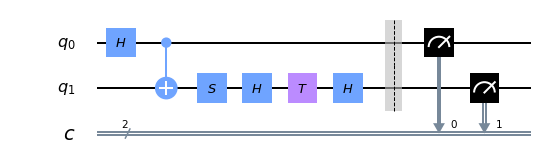

In [9]:
###################################
# create circuit AB
###################################

# here create the bell state(phi+)
qc = create_qc()

# A
# qc.z(1)

# B
qc.s(1)
qc.h(1)
qc.t(1)
qc.h(1)
qc.barrier()

# Measurement
qc.measure(0, 0)
qc.measure(1, 1)

# show the qc
qc.draw(output='mpl')

In [10]:
# Show the result
counts_AB = execute(qc, backend, shots=shots).result().get_counts()
print("counts = ", counts_AB)

# Estimation value of AB
# sort and normalize
AB = [counts_AB[i]/shots for i in bin] 
E_AB = AB[0] - AB[1] - AB[2] + AB[3] # where ;  ⟨𝐴𝐵⟩=p(|00>) - p(|01>) − p(|10>) + p(|11>)
print("\nExpected value of AB : %f" % E_AB)

counts =  {'00': 42897, '01': 7329, '10': 7231, '11': 42543}

Expected value of AB : 0.708800


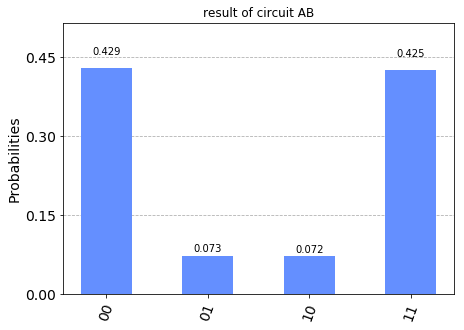

In [11]:
plot_histogram(counts_AB, title="result of circuit AB")

### 2. Circuit for Ab

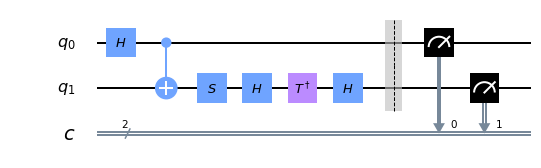

In [12]:
###################################
# create circuit Ab
###################################

# here create the bell state(phi+)
qc = create_qc()

# A

# b
qc.s(1)
qc.h(1)
qc.tdg(1)
qc.h(1)
qc.barrier()

# Measurement
qc.measure(0, 0)
qc.measure(1, 1)

# show the qc
qc.draw(output='mpl')

In [13]:
# get counts from execution
counts_Ab = execute(qc, backend, shots=shots).result().get_counts()
print("counts = ", counts_Ab)

# Estimation value of Ab
# sort and normalize 
Ab = [counts_Ab[i]/shots for i in bin] 
E_Ab = Ab[0] - Ab[1] - Ab[2] + Ab[3] # where ;  ⟨Ab⟩=p(|00>) - p(|01>) − p(|10>) + p(|11>)
print("\nExpected value of Ab : %f" % E_Ab)

counts =  {'00': 42626, '01': 7383, '10': 7444, '11': 42547}

Expected value of Ab : 0.703460


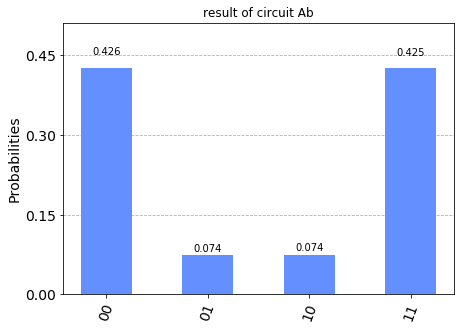

In [14]:
plot_histogram(counts_Ab, title="result of circuit Ab")

### 3. Circuit for aB

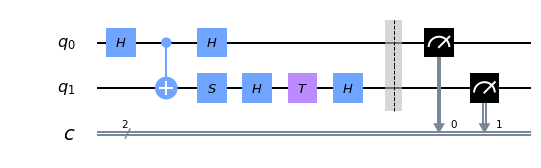

In [15]:
###################################
# create circuit aB
###################################

# here create the bell state(phi+)
qc = create_qc()

# a
qc.h(0)

# B
qc.s(1)
qc.h(1)
qc.t(1)
qc.h(1)
qc.barrier()

# Measurement
qc.measure(0, 0)
qc.measure(1, 1)

# show the qc
qc.draw(output='mpl')

In [16]:
# get counts from execution
counts_aB = execute(qc, backend, shots=shots).result().get_counts()
print("counts = ", counts_aB)

# Estimation value of aB
# sort and normalize
aB = [counts_aB[i]/shots for i in bin] 
E_aB = aB[0] - aB[1] - aB[2] + aB[3] # where ;  ⟨a𝐵⟩=p(|00>) - p(|01>) − p(|10>) + p(|11>)
print("\nExpected value of Ab : %f" % E_aB)

counts =  {'00': 42734, '01': 7212, '10': 7394, '11': 42660}

Expected value of Ab : 0.707880


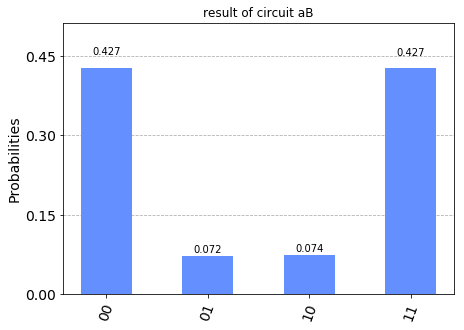

In [17]:
plot_histogram(counts_aB, title="result of circuit aB")

### 4. Circuit for ab

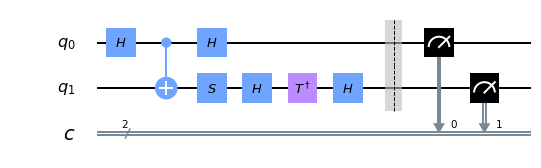

In [18]:
###################################
# create circuit ab
###################################

# here create the bell state(phi+)
qc = create_qc()

# a
qc.h(0)

# b
qc.s(1)
qc.h(1)
qc.tdg(1)
qc.h(1)
qc.barrier()

# Measurement
qc.measure(0, 0)
qc.measure(1, 1)

# show the qc
qc.draw(output='mpl')

In [19]:
# get counts from execution
counts_ab = execute(qc, backend, shots=shots).result().get_counts()
print("counts = ", counts_ab)

# Estimation value of ab
# sort and normalize
ab = [counts_ab[i]/shots for i in bin] 
E_ab = ab[0] - ab[1] - ab[2] + ab[3] # where ;  ⟨ab⟩=p(|00>) - p(|01>) − p(|10>) + p(|11>)
print("\nExpected value of Ab : %f" % E_ab)

counts =  {'00': 7268, '01': 42612, '10': 42616, '11': 7504}

Expected value of Ab : -0.704560


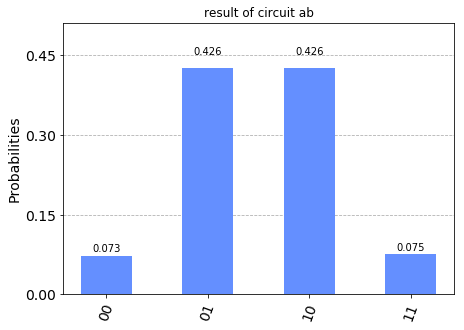

In [20]:
plot_histogram(counts_ab, title="result of circuit ab")

### Calculate S value

In [21]:
# calculate S value
print(abs(E_AB + E_Ab+ E_aB - E_ab))

2.8246999999999995


In [22]:
# Show 2√2
print(2*np.sqrt(2))

2.8284271247461903
